In [10]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [91]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD'])]
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_prcies = fe.preprocess_data(df.query('date>"2005-01-01"'))
cleaned_data = processed_prcies.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
stock_dimension = len(cleaned_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 6


In [92]:
# Compute exponentially weighted std of log returns
for window in [21, 42, 63,252]:
    cleaned_data[f'std_return_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .ewm(span=window, min_periods=1,adjust=False).std().values
# Compute exponentially weighted std of closing prices for MACD normalization
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'] \
    .ewm(span=63, min_periods=1).std().values

# Normalize MACD by price volatility
cleaned_data['macd_normal'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63']

# Rolling cumulative log returns over different periods
for window in [5, 21, 42, 63,252]:
    cleaned_data[f'price_lag_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .rolling(window=window, min_periods=1).sum().values

# Normalize rolling log returns by their respective volatilities
for window in [21, 42, 63,252]:
    cleaned_data[f'r_{window}'] = cleaned_data[f'price_lag_{window}'] / cleaned_data[f'std_return_{window}']

# Normalize RSI (if needed)
cleaned_data['rsi'] = cleaned_data['rsi_30'] / 100

In [96]:
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 6


In [97]:
train_data.isna().sum()

Unnamed: 0           0
date                 0
open                 0
high                 0
low                  0
close                0
volume               0
tic                  0
day                  0
macd                 0
rsi_30               0
return               0
log_return           0
std_return_21        0
std_return_42        0
std_return_63        0
std_return_252       0
ewma_std_price_63    0
macd_normal          0
price_lag_5          0
price_lag_21         0
price_lag_42         0
price_lag_63         0
price_lag_252        0
r_21                 0
r_42                 0
r_63                 0
r_252                0
rsi                  0
dtype: int64

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
optimizer.train_model(train_data,
                        validation_data,
                        features=["close", "log_return","r_21"
                                  ,"r_42","r_63","r_252",
                                  "macd","rsi"
                                  ],
                        model_name="ppo",
                        args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
                        window_size=60,
                        iterations=400_000)
# test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
#                                 "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
#                                   ],window=60)
# ppo_test_result = optimizer.load_from_file(
#     'ppo',test_env, 
#     cwd="data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps"
#     ,deterministic=True)

In [7]:
from pypfopt import expected_returns
from pypfopt import risk_models

def mvo_data(data, TEST_START_DATE, TEST_END_DATE, returns_model='ema_historical_return',risk_model='ledoit_wolf'):
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        covs = risk_models.risk_matrix(price_lookback,method=risk_model)
        mu.append(expected_returns.return_model(price_lookback,method=returns_model,compounding=False))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df

In [98]:
TEST_START_DATE = '2021-03-29'
TEST_END_DATE = '2023-01-01'

In [101]:
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='mean_historical_return',risk_model='sample_cov')

begin_total_asset:50000
end_total_asset:52365.94550929549
Sharpe:  0.2440061927820404
Test Finished!
episode_return 1.0473189101859097


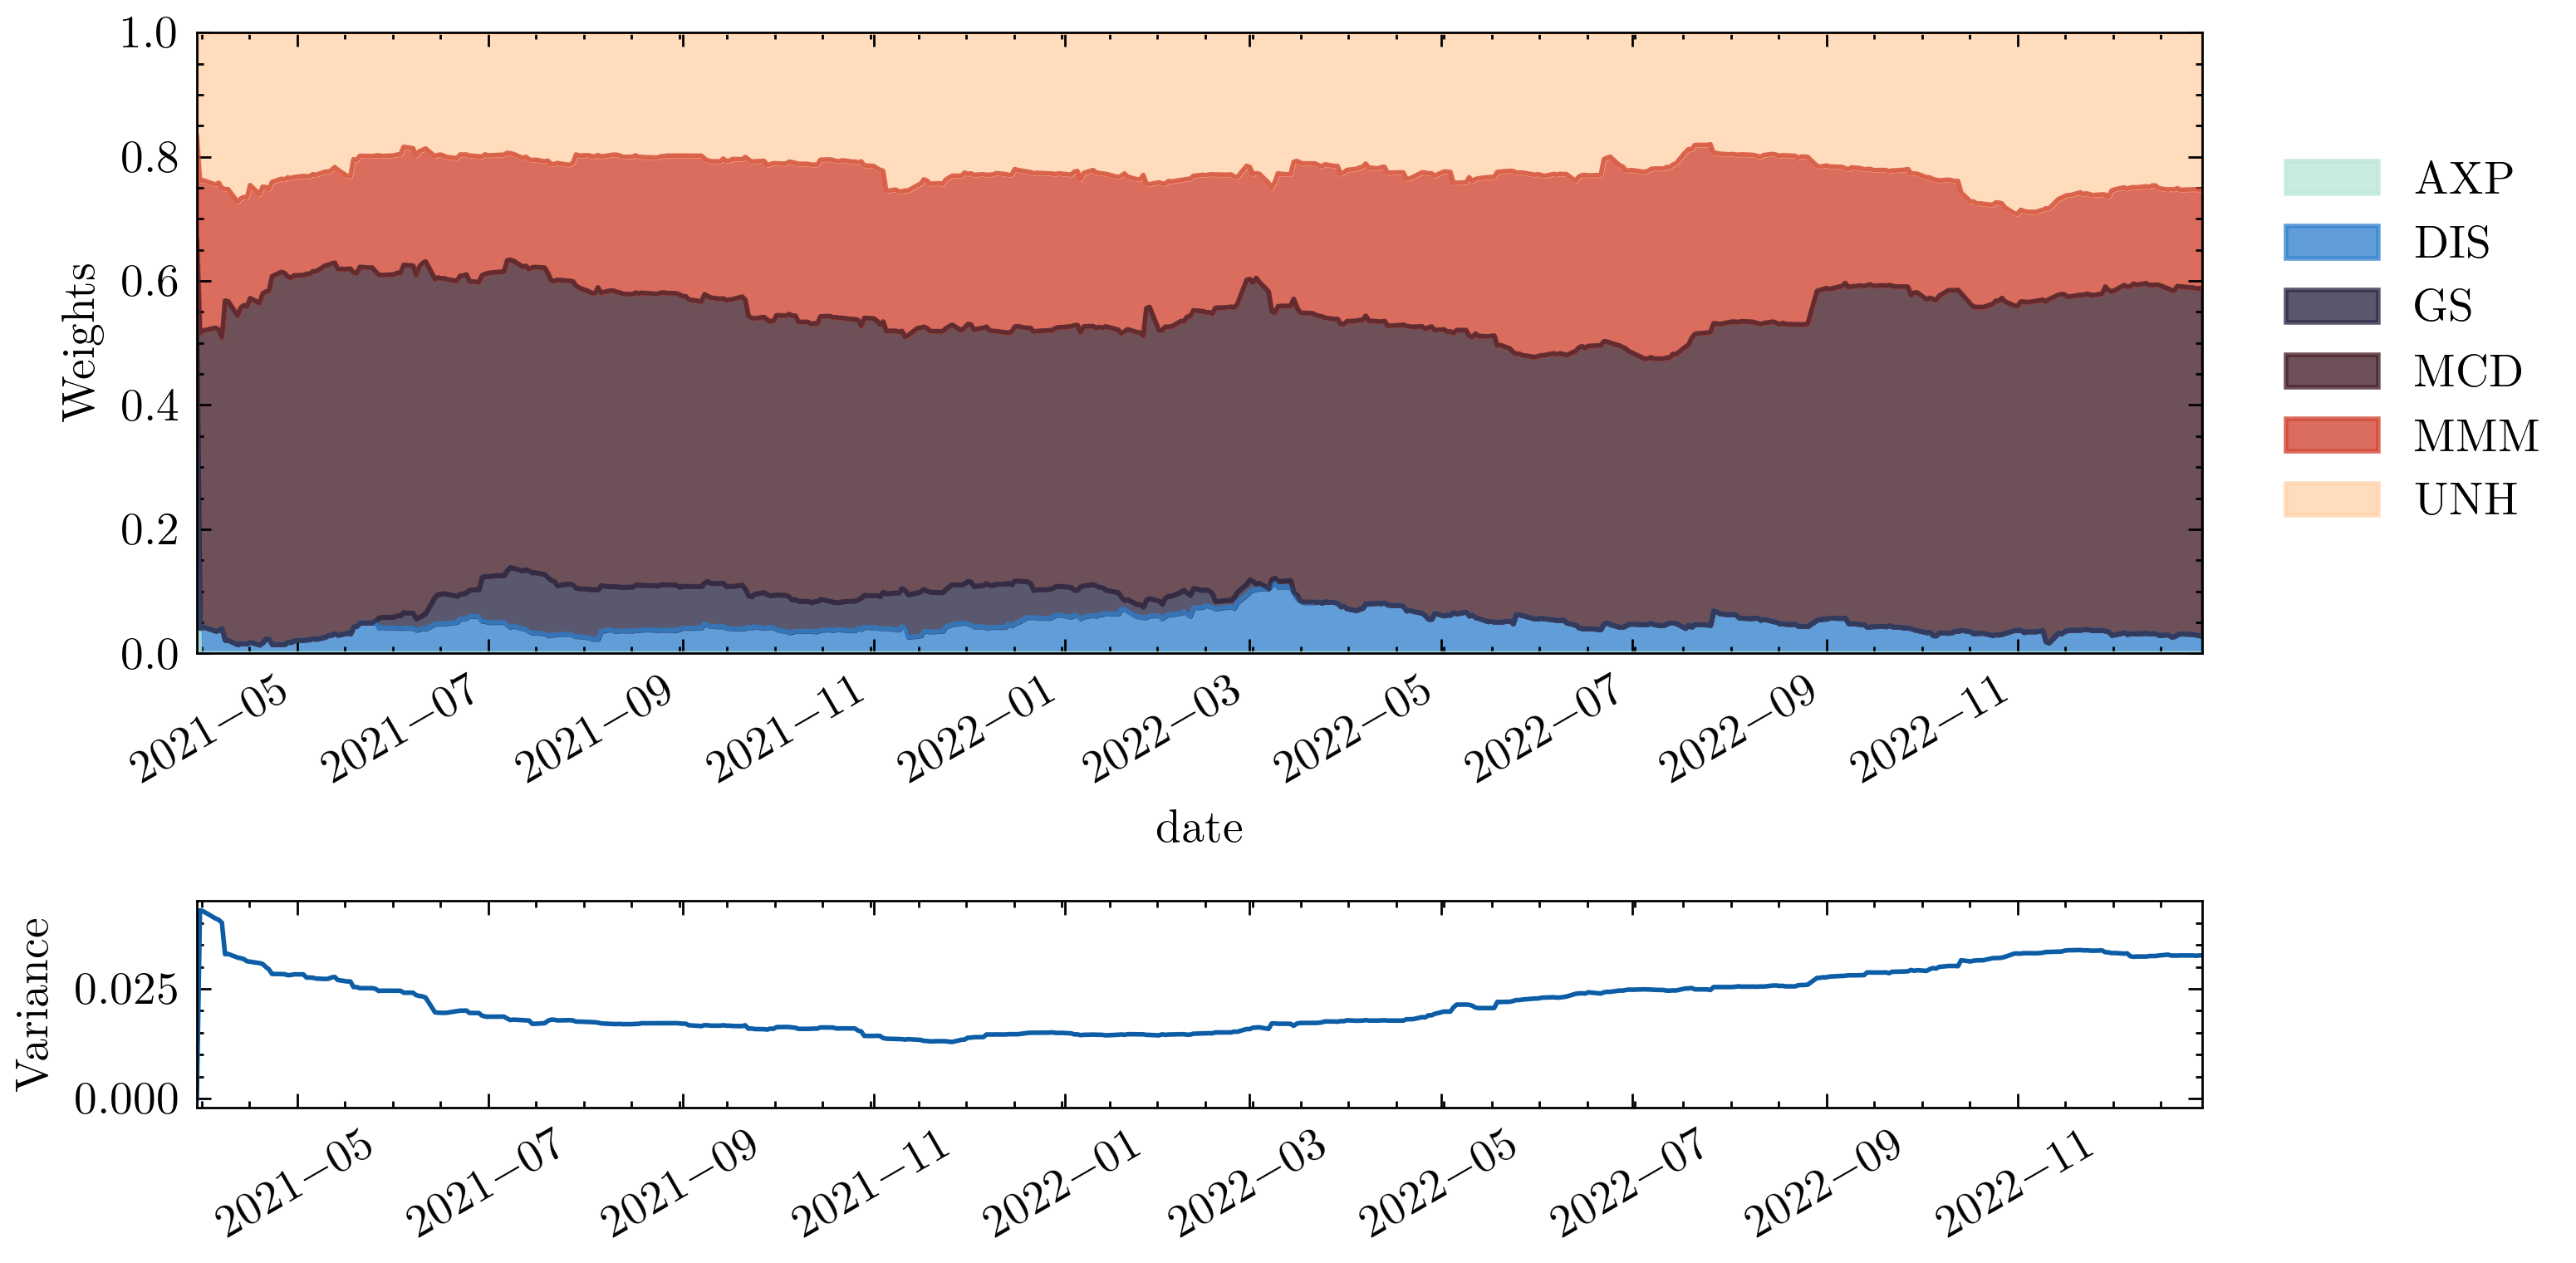

In [103]:
min_variacen_portfolio = mvo.mean_variance_optimization(covariances,pct=0)
%matplotlib inline
plot_mvo_weights(min_variacen_portfolio,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_sample_cov_mean_min_var.png')

begin_total_asset:50000
end_total_asset:60199.58013861658
Sharpe:  0.6391294310830077
Test Finished!
episode_return 1.2039916027723316


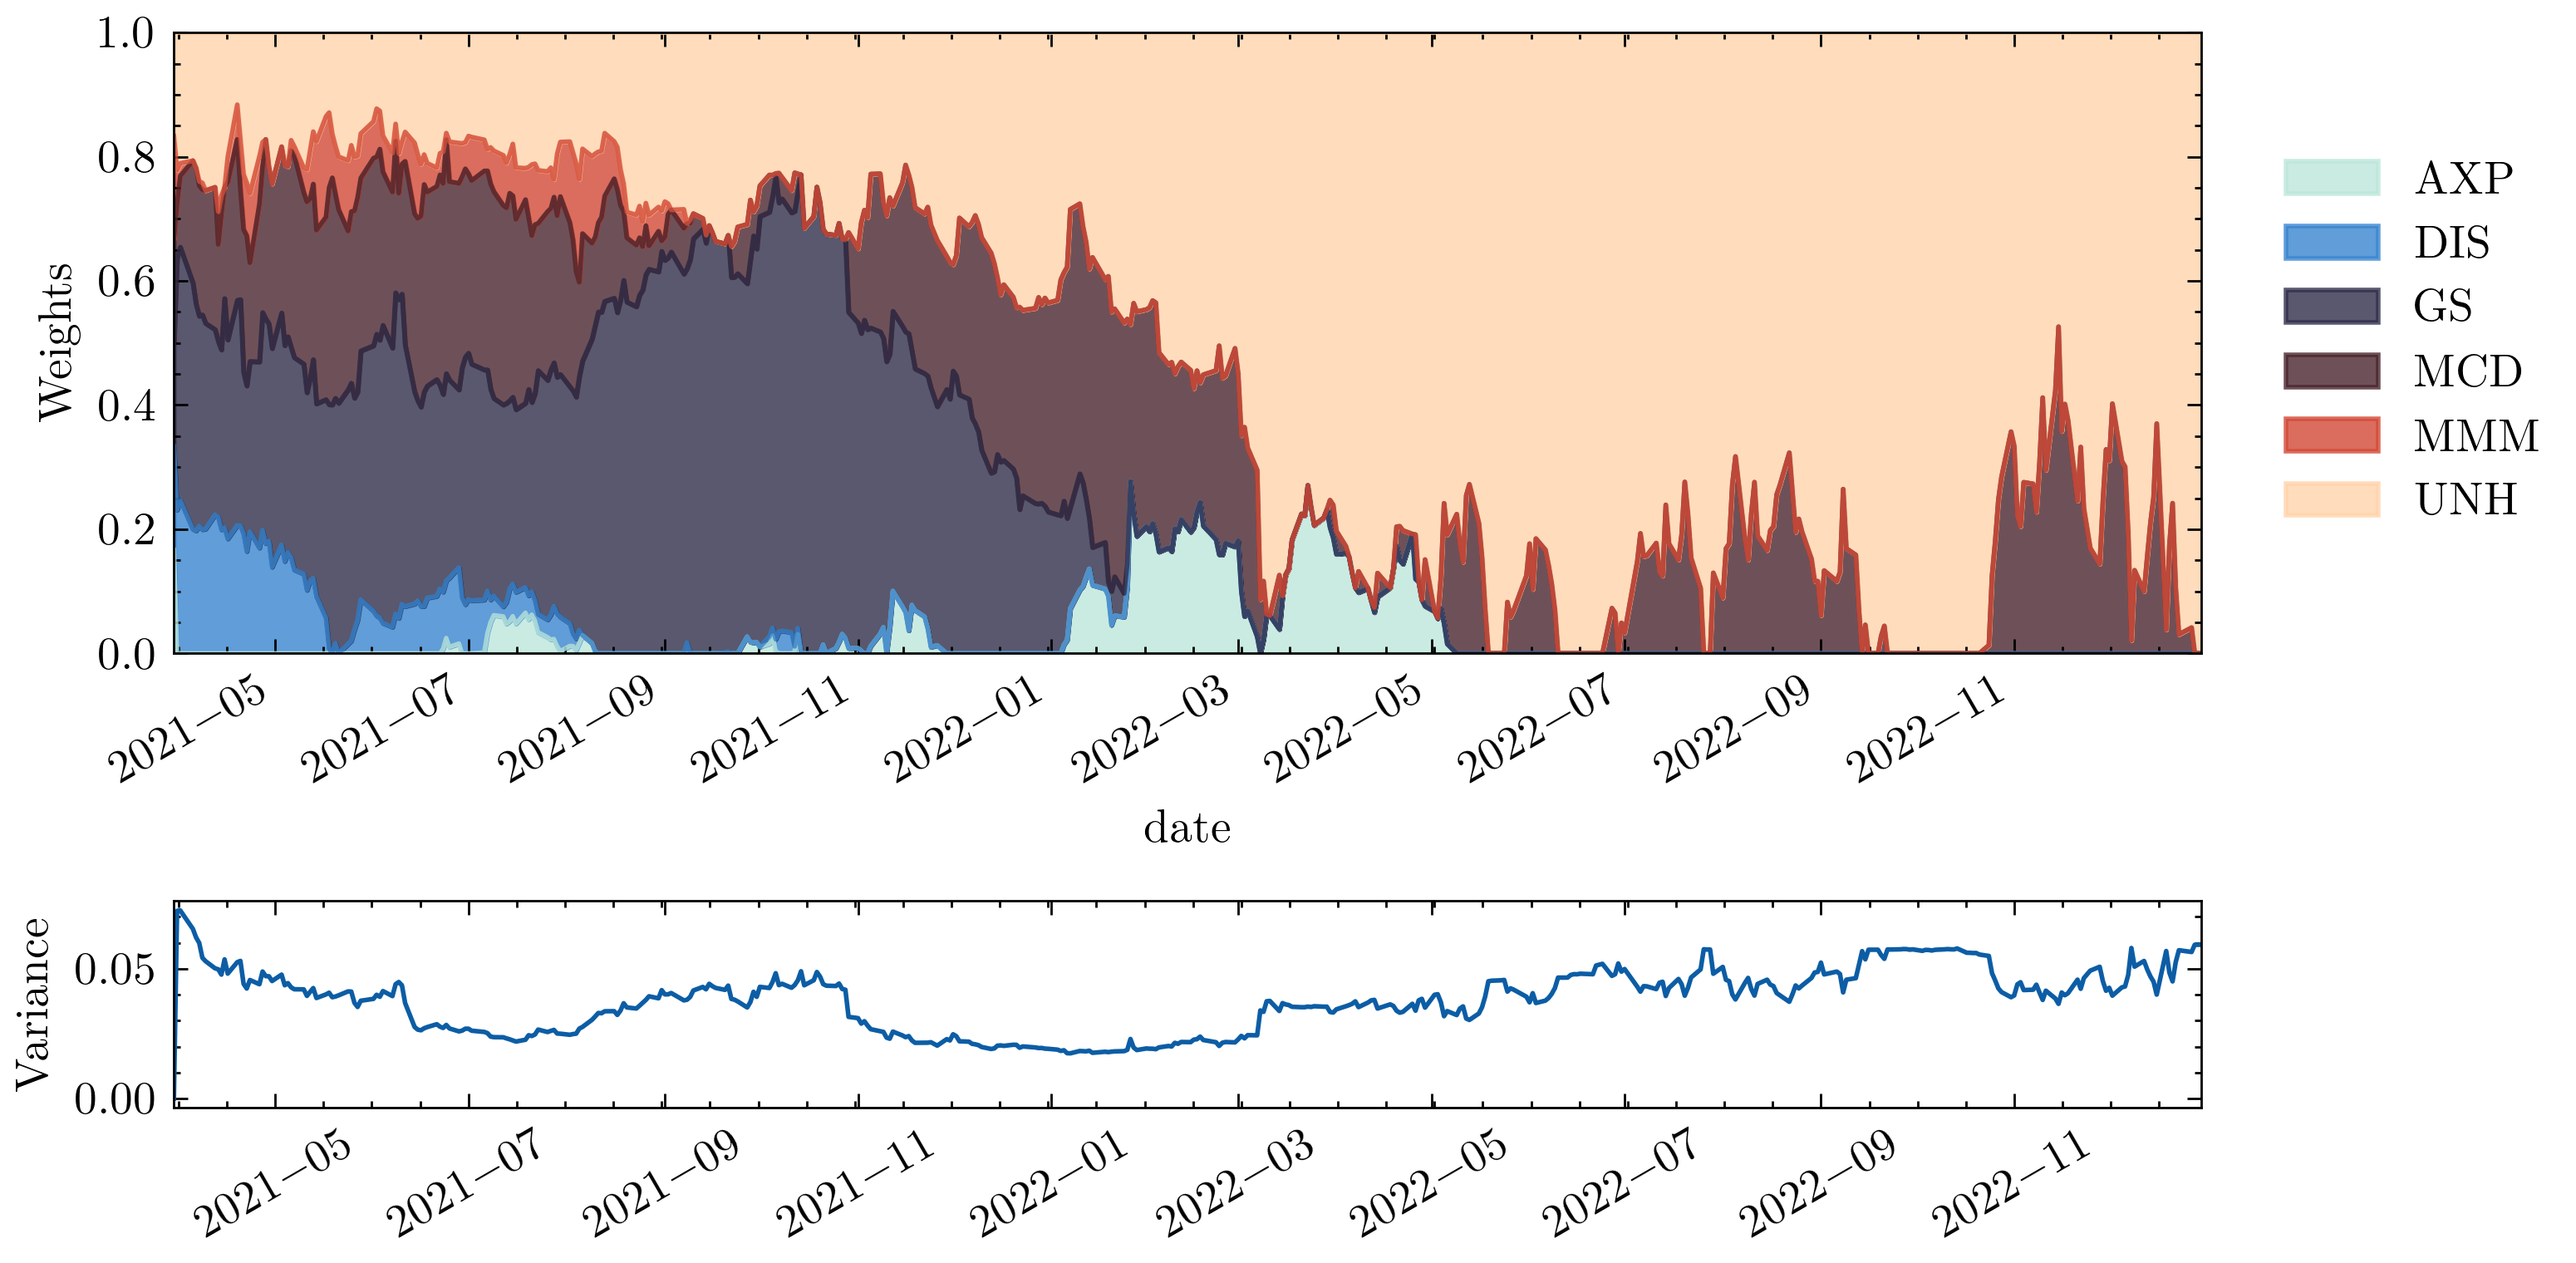

In [104]:
result_sharpe = mvo.mean_variance_optimization(covariances,pct=0,objective='sharpe')
%matplotlib inline
plot_mvo_weights(result_sharpe,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_sample_cov_mean_sharpe.png')

begin_total_asset:50000
end_total_asset:55198.70029408053
Sharpe:  0.34180066743617715
Test Finished!
episode_return 1.1039740058816105


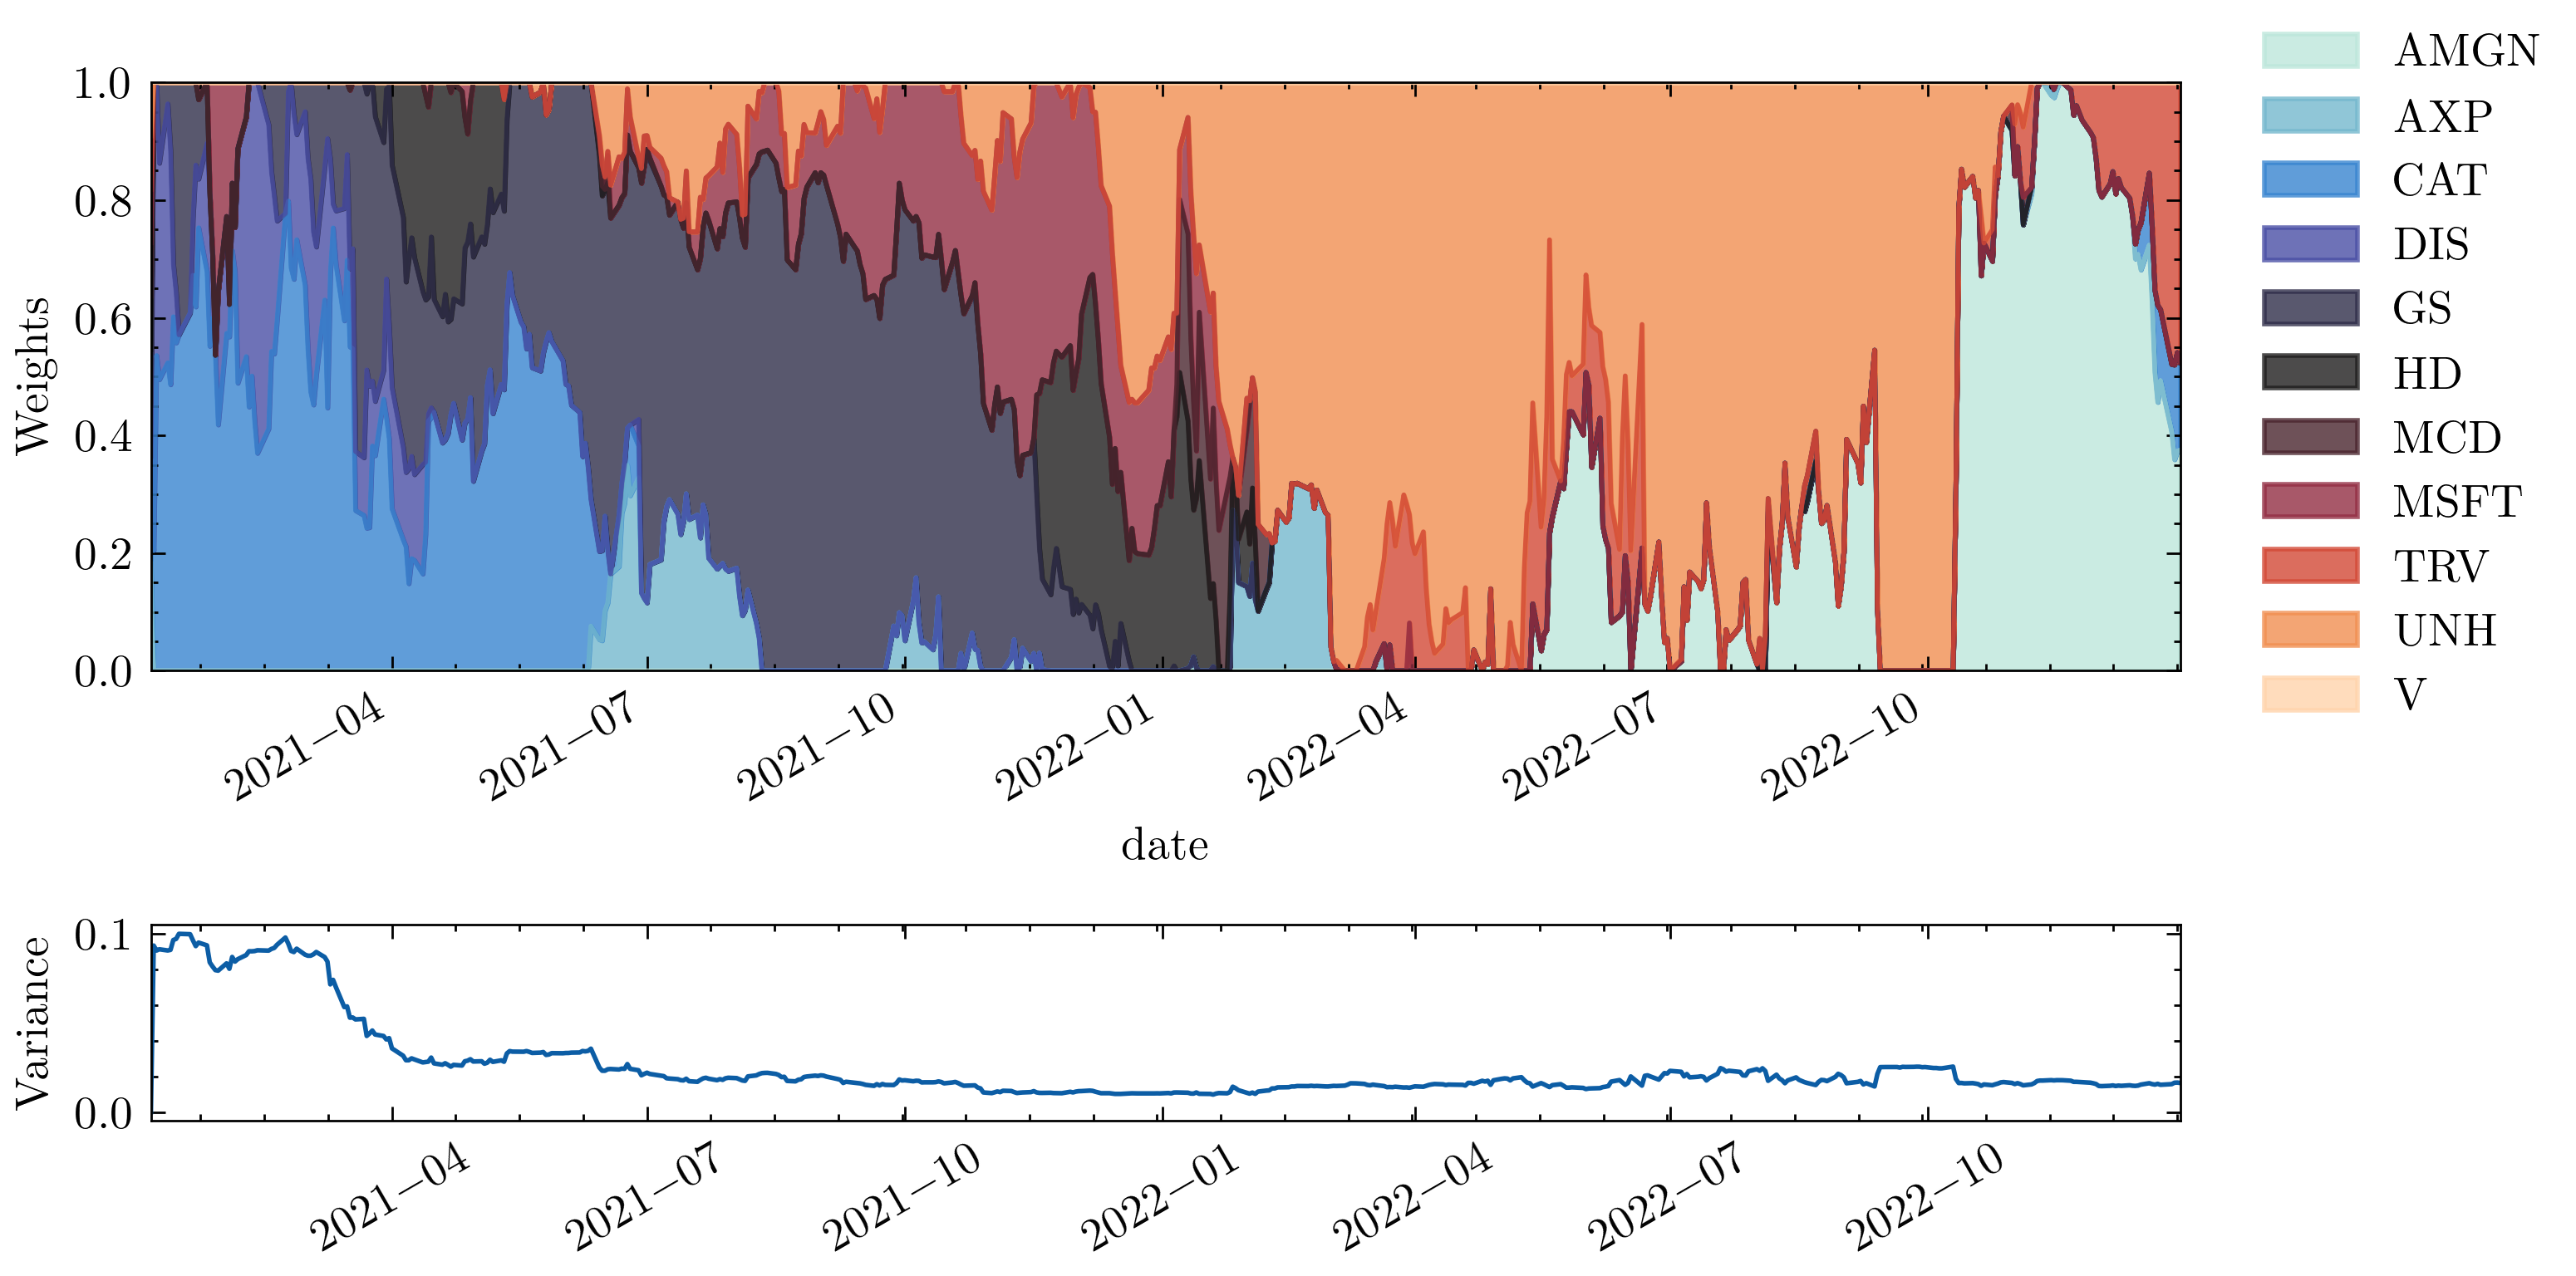

In [ ]:
TEST_START_DATE = '2021-03-30'
TEST_END_DATE = '2023-01-01'
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='ema_historical_return',risk_model='semicovariance')
res = mvo.mean_variance_optimization(covariances,pct=0,objective='sharpe')
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_exponential_semi_cov_sharpe.png')

PPO WITHOUT WEIGHT

Use normalization

In [136]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps"
    ,deterministic=True)


Successfully load model data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps
Initial portfolio value:250000
Final portfolio value: 262199.625
Final accumulative portfolio value: 1.0487984418869019
Maximum DrawDown: -0.2204810883074637
Sharpe ratio: 0.23582026443643747


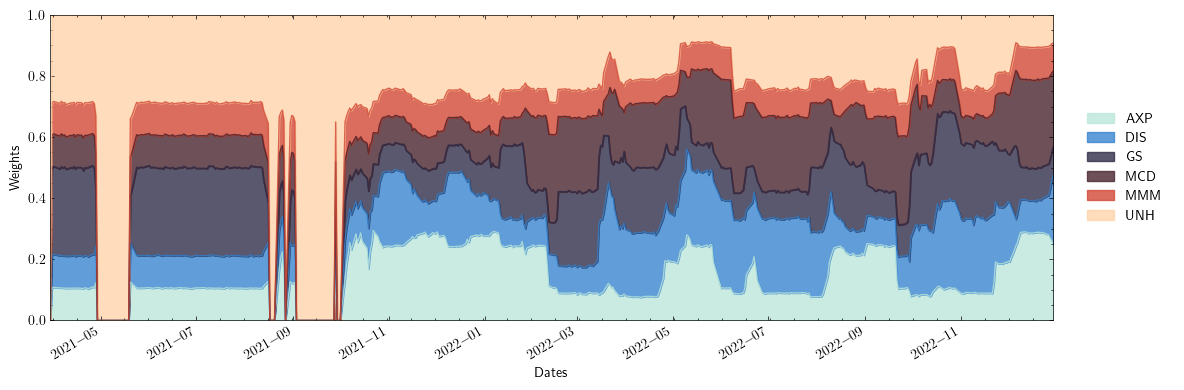

In [137]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

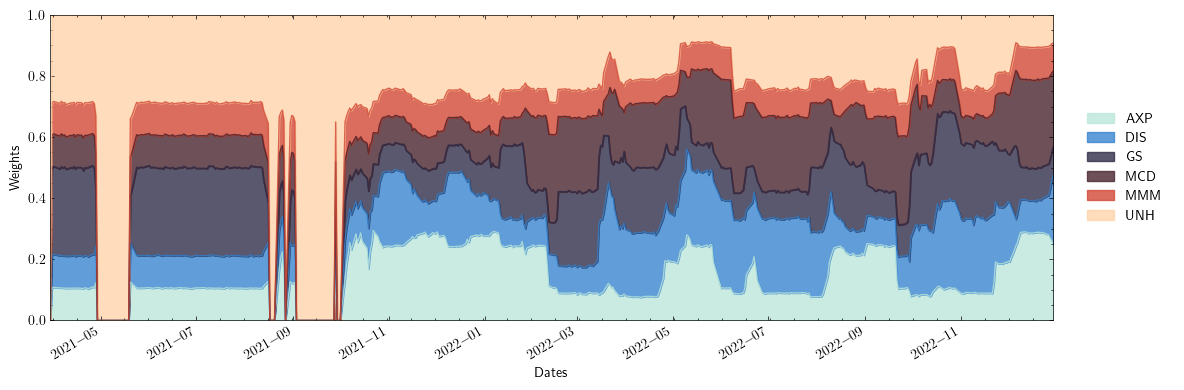

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

In [111]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
a2c_test_result = optimizer.load_from_file(
    'a2c',test_env, 
    cwd="data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps"
    ,deterministic=True)


Successfully load model data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps
Initial portfolio value:250000
Final portfolio value: 192655.375
Final accumulative portfolio value: 0.7706214785575867
Maximum DrawDown: -0.34089284004725384
Sharpe ratio: -0.5424350110453228


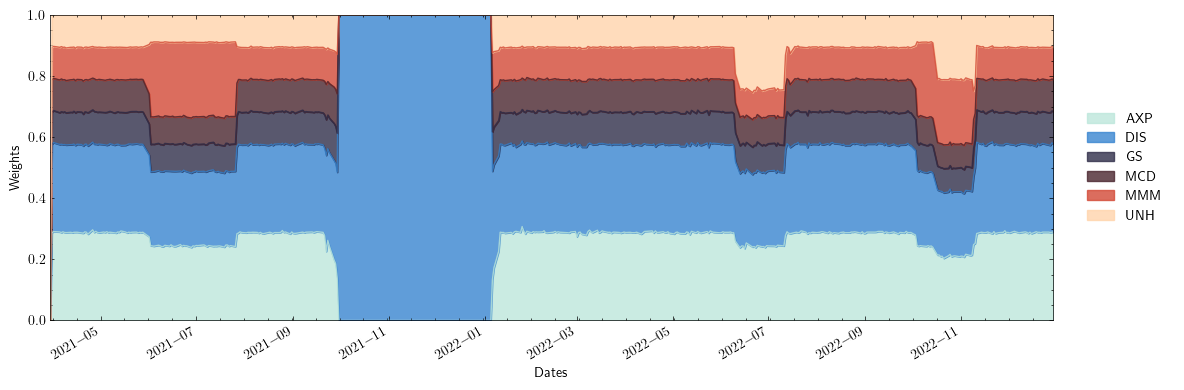

In [112]:
from utils.plotting_helpers import plot_weights
plot_weights(a2c_test_result[0].weights, a2c_test_result[0].date, a2c_test_result[1],add_cash=False)

Struggles with rew

In [117]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=60,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 948644.0
Final accumulative portfolio value: 0.9486439824104309
Maximum DrawDown: -0.22713165755853804
Sharpe ratio: -0.06122215468658751


In [26]:
ppo_test_result[0]

,date,daily_return,account,weights
0,2021-03-30,0.000000,250000.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2021-03-31,-0.006214,248446.515625,"[0.044483244, 0.1200004, 0.120744735, 0.120714..."
2,2021-04-01,0.009116,250711.281250,"[0.04378715, 0.12148407, 0.119299844, 0.121720..."
3,2021-04-05,0.009144,253003.718750,"[0.04606191, 0.12506914, 0.12413302, 0.1234854..."
4,2021-04-06,-0.002756,252306.453125,"[0.04860416, 0.13375093, 0.11701457, 0.1345407..."
...,...,...,...,...
439,2022-12-23,0.005436,276824.187500,"[0.1254476, 0.083120964, 0.046838865, 0.105099..."
440,2022-12-27,-0.003511,275852.281250,"[0.110441186, 0.074421324, 0.047481943, 0.1154..."
441,2022-12-28,-0.011138,272779.718750,"[0.054806724, 0.073702134, 0.047949683, 0.1290..."
442,2022-12-29,0.015057,276887.031250,"[0.04557142, 0.08331371, 0.069486044, 0.127457..."


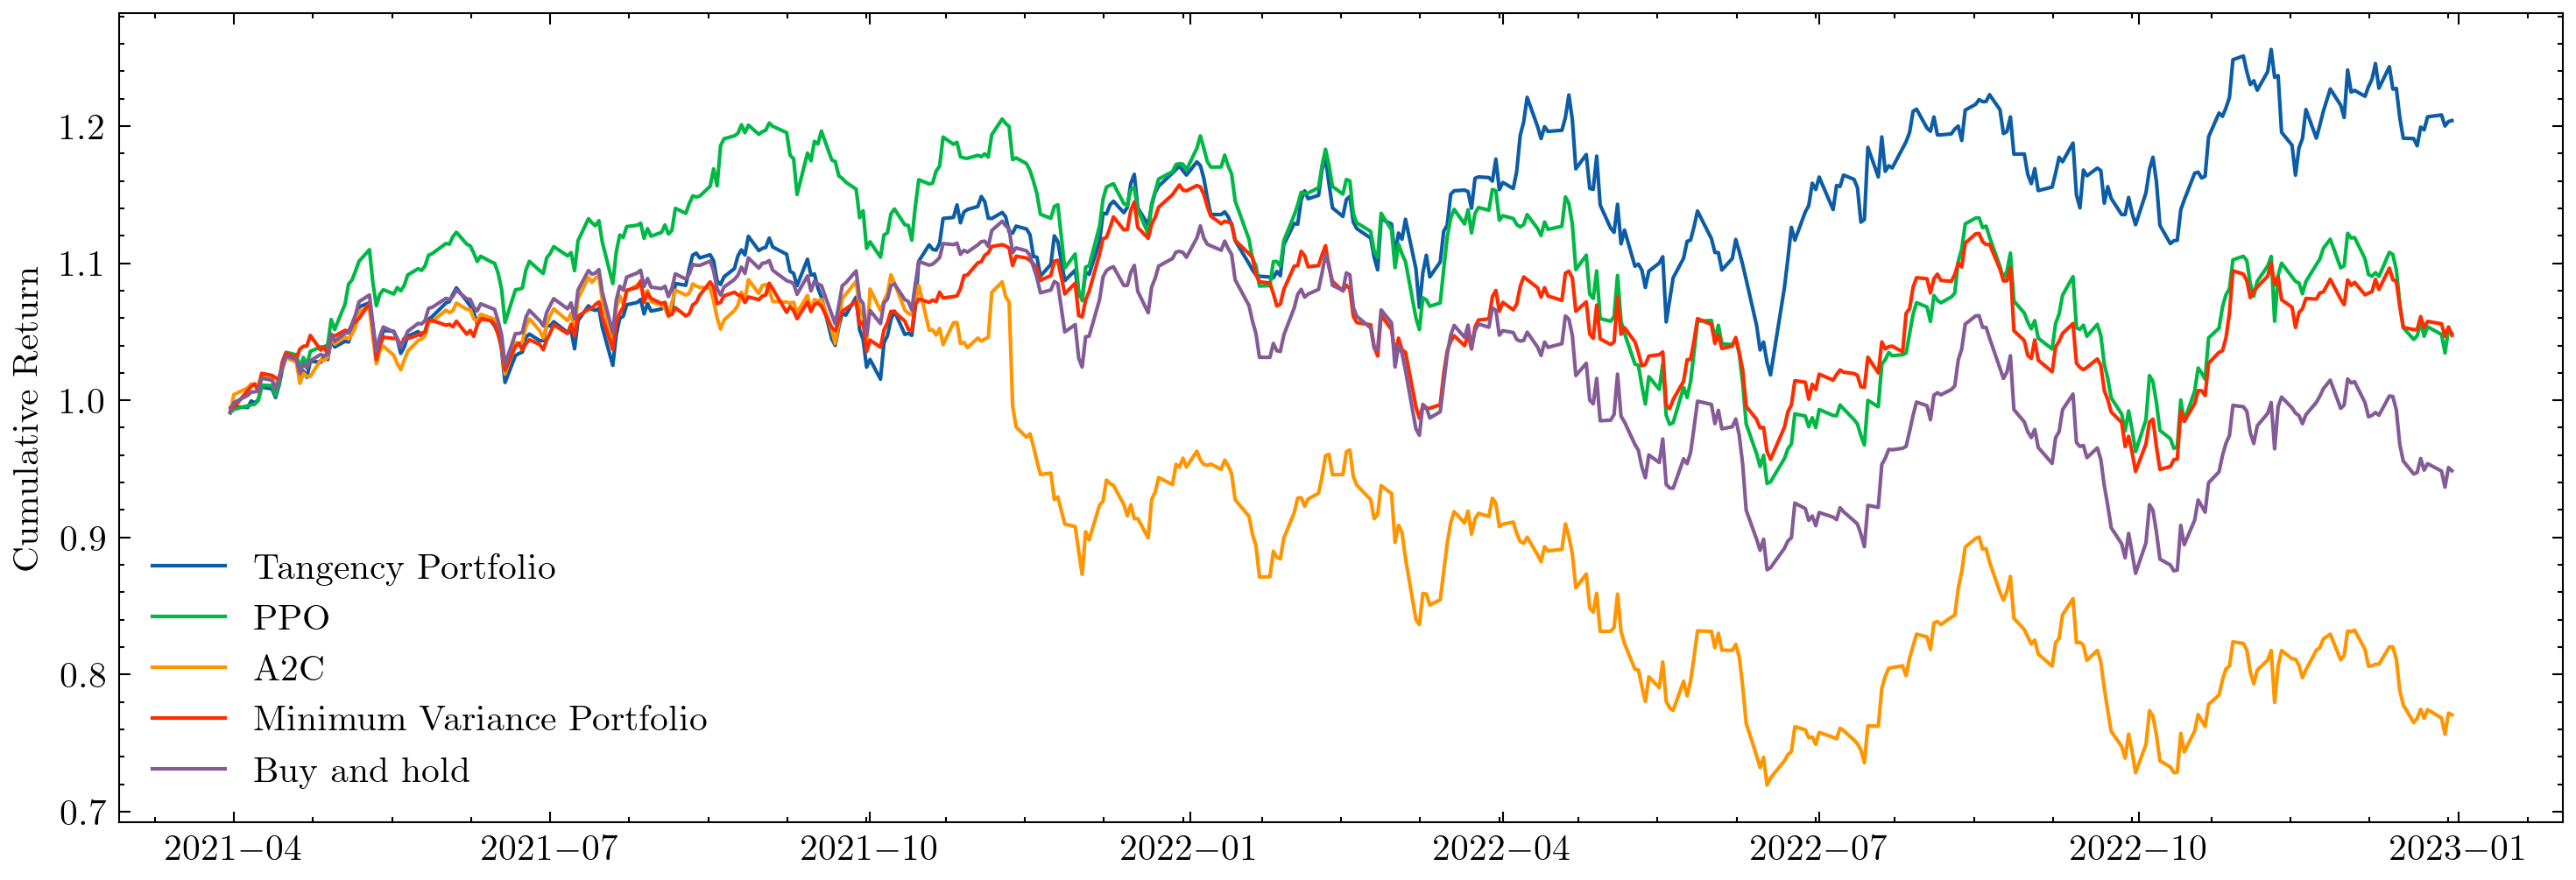

In [118]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

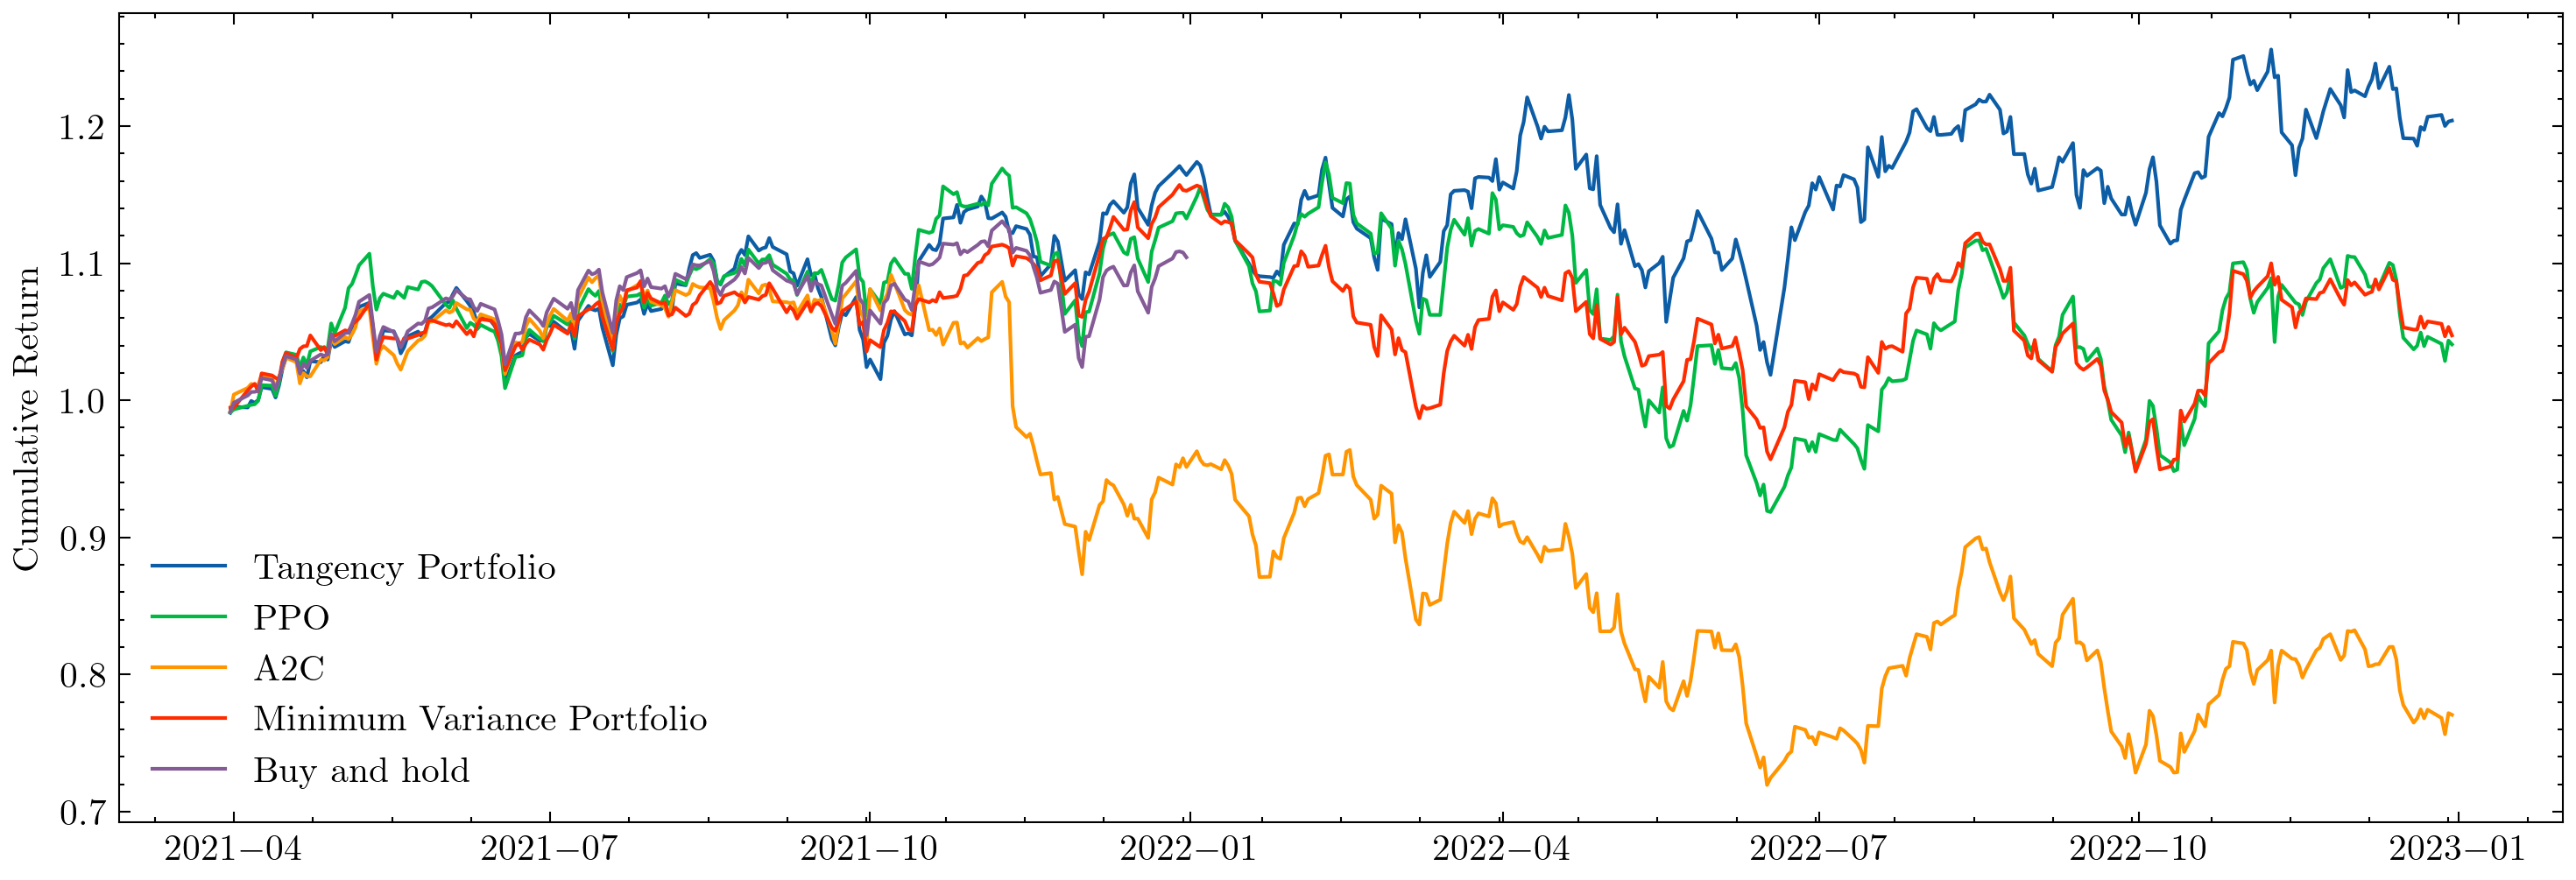

In [113]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [87]:
import quantstats as qs

In [213]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.3388092143131057),
 'max_drow_down': np.float64(-0.2664428956423516),
 'var': -0.02301269977821848,
 'return': np.float64(0.09390949999999965)}

In [214]:
mvo_min_returns = min_variacen_portfolio['test'][['date','total_assets']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['total_assets']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['total_assets']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['total_assets'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.2633164866290335),
 'max_drow_down': np.float64(-0.18063587669076375),
 'var': -0.01639642306661718,
 'return': np.float64(0.05302095955995423)}

In [215]:

mvo_sharpe_returns = result_sharpe['test'][['date','total_assets']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['total_assets'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.666227580986604),
 'max_drow_down': np.float64(-0.16693110888675866),
 'var': -0.019609587852893476,
 'return': np.float64(0.21507314715763637)}

In [216]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(-0.06122215468658751),
 'max_drow_down': np.float64(-0.22713166127519646),
 'var': -0.019835048058484694,
 'return': np.float64(-0.051356343491552825)}

In [217]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats]

In [218]:
stats_df = pd.DataFrame(stats)

In [219]:
stats_df

,name,sharpe_ratio,max_drow_down,var,return
0,Buy and Hold,-0.061222,-0.227132,-0.019835,-0.051356
1,Tangency Portfolio,0.666228,-0.166931,-0.019610,0.215073
2,Min variance portfolio,0.263316,-0.180636,-0.016396,0.053021
3,Proximal Policy Optimization,0.338809,-0.266443,-0.023013,0.093909


In [220]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())